In [1]:
# Importa librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Semilla para replicabilidad
SEED = 42

In [3]:
# Lectura de vectores latente de npy (según división en autoencoder)
latent_vectors_test = np.load('../vectors/test/test_latent_vector_55112.npy') # Acá hay q cambiar para otros tamaño de vec. latentes
latent_vectors_val = np.load('../vectors/val/val_latent_vector_55112.npy') # Acá hay q cambiar para otros tamaño de vec. latentes
latent_vectors_train = np.load('../vectors/train/train_latent_vector_55112.npy') # Acá hay q cambiar para otros tamaño de vec. latentes

# Lectura de npy de labels (según división en autoencoder)
labels_test = np.load('../vectors/test/test_labels.npy')
labels_val = np.load('../vectors/val/val_labels.npy')
labels_train = np.load('../vectors/train/train_labels.npy')

# Lectura de npy originales (según división en autoencoder)
original_test = np.load('../vectors/test/test_originales.npy')
original_val = np.load('../vectors/val/val_originales.npy')
original_train = np.load('../vectors/train/train_originales.npy')

# A pd los vectores (cada fila un vector, cada columna un atributo)
lv_train = pd.DataFrame(np.vstack((latent_vectors_train, latent_vectors_val)))
lv_test = pd.DataFrame(latent_vectors_test)

# A pd las labels
labels_train = np.hstack((labels_train, labels_val))

# A pd los vectores originales (cada fila un vector, cada columna un atributo)
og_train = pd.DataFrame(np.vstack((original_train, original_val)))
og_test = pd.DataFrame(original_test)

# Chequeo de dataset de dimensiones
print(lv_train.info())
print(lv_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Columns: 55112 entries, 0 to 55111
dtypes: float32(55112)
memory usage: 73.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 55112 entries, 0 to 55111
dtypes: float32(55112)
memory usage: 21.0 MB
None


In [ ]:
latent_size = latent_vectors_test.shape[1]

## K-means

Para el vector latente reducido

In [ ]:
k = 10
kmeans_lv = make_pipeline(StandardScaler(), KMeans(n_clusters=k, max_iter=30, n_init=20, random_state=SEED))
kmeans_lv.fit(lv_train)
print(kmeans_lv[1].labels_)

Para el vector original

In [ ]:
k = 10
kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=k, max_iter=30, n_init=20, random_state=SEED))
kmeans.fit(og_train)
print(kmeans[1].labels_)

Para graficar el gráfico de elbow

In [ ]:
evol_variabilidad = []
for k in range(1, 41):
    kmeans = KMeans(n_clusters=k, max_iter=30, n_init=20)
    kmeans.fit(lv_train)
    evol_variabilidad.append({"k": k, "var": kmeans.inertia_})

evol_variabilidad = pd.DataFrame(evol_variabilidad)
plt.figure()
plt.plot(evol_variabilidad["k"], evol_variabilidad["var"], marker="o")
plt.xlabel("k")
plt.ylabel("within-cluster variation")
plt.show()

## Decision Tree

##### Entrenamiento y testeo

In [ ]:
# Entrenamiento del árbol
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(og_train, labels_train)

# Predicción
labels_pred = clf.predict(og_test)

# Métrica
print("Accuracy:", metrics.accuracy_score(labels_test, labels_pred))

##### Feature importance

In [ ]:
# Get feature importances from the trained model
feature_importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Num of top features
num_top_features = 100

# Get the indices of the top 'num_top_features' most important features
top_indices = indices[:num_top_features]

# Print feature ranking
# print("Feature ranking:")
# for f in range(lv_train.shape[1]):
#     print(f"{f + 1}. Feature {indices[f]} ({feature_importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title(f"Top {num_top_features} Feature Importances (vector size = 1x{latent_size})")
plt.bar(range(num_top_features), feature_importances[top_indices], align="center")
plt.xticks(range(num_top_features), top_indices, rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

## PCA

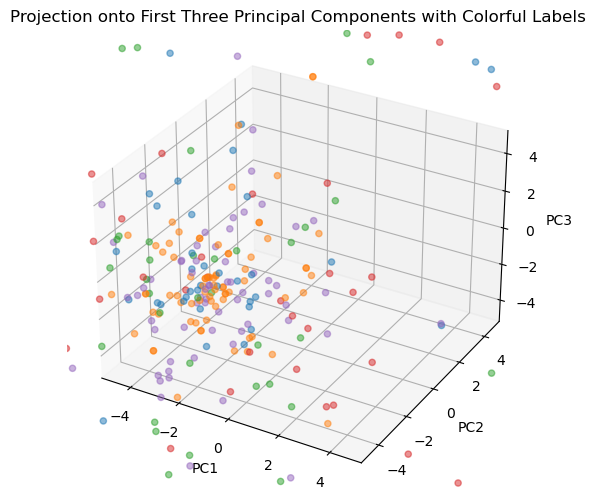

In [4]:
# Escalado del vector
scaler = StandardScaler(with_std=True, with_mean=True)
# Fiteo (calculo de mean y std) con train
scaler.fit(lv_train)
# Aplico transformación
scaled_lv_train = pd.DataFrame(scaler.transform(lv_train)) # aca cambiar lv_train o og_train

# Definición de PCA
pca = PCA()
# Fiteo de PCA sobre train escalado
pca.fit(scaled_lv_train)

loadings = pca.components_

# Transformo la data en el subespacio dado por las componentes principales
transformed_data = pca.transform(scaled_lv_train)

# Extracción de las primeras 3 componentes principales
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Definició de colores de los géneros
unique_labels = pd.Series(labels_train).unique()
colors = plt.cm.tab10.colors[:len(unique_labels)]
label_color_map = {label: color for label, color in zip(unique_labels, colors)}
point_colors = [label_color_map[label] for label in labels_train]

# Creación del plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-5, 5])  # Set limits for x-axis
ax.set_ylim([-5, 5])  # Set limits for y-axis
ax.set_zlim([-5, 5])  # Set limits for z-axis

# Plotting the projection onto the first three principal components with colors based on labels
ax.scatter(pc1, pc2, pc3, c=point_colors, marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Proyección sobre las 3 Componentes Principales (color según género)')

plt.show()

In [5]:
# Definición de árbol
clf = DecisionTreeClassifier(random_state=SEED)
# Entrenamiento del árbol con data transformada (reducida de dimensión)
clf.fit(transformed_data, labels_train)

# Predicción sobre data de test escalada y transformada con según train
scaled_lv_test = pd.DataFrame(scaler.transform(lv_test))
labels_pred = clf.predict(pca.transform(scaled_lv_test))

# Métrica
print("Accuracy:", metrics.accuracy_score(labels_test, labels_pred))

Accuracy: 0.24


Código viejo:

In [ ]:
# scaler = StandardScaler(with_std=True, with_mean=True)
# scaled_lv = pd.DataFrame(scaler.fit_transform(lv_train))

# pca = PCA()
# pca.fit(scaled_lv)

# # Crea un DataFrame para almacenar los resultados del PCA
# scores = pd.DataFrame(pca.transform(scaled_lv), index=scaled_lv.index)

# def plot_biplot(pca_res, scores):
#     """
#     Función para crear un gráfico biplot a partir de los resultados del PCA.
#     """
#     i, j = 0, 1
#     _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
#     # Grafica las puntuaciones en el espacio de las dos primeras componentes principales
#     ax.scatter(scores.values[:, 0], scores.values[:, 1])
#     ax.set_xlabel('PC%d' % (i + 1))
#     ax.set_ylabel('PC%d' % (j + 1))

#     unique_labels = pd.Series(labels_train).unique()
#     label_colors = plt.cm.tab10.colors[:len(unique_labels)]  # Choosing colors from a predefined colormap
    
#     for idx, label in enumerate(unique_labels):
#         mask = labels_train == label
#         ax.scatter(scores.values[mask, 0], scores.values[mask, 1], label=label, c=[label_colors[idx]])

#     ax.legend()  # Show legend with labels
    
#     # Agrega líneas verticales y horizontales en el origen
#     ax.axvline(0, color='lightgray', linestyle='--')
#     ax.axhline(0, color='lightgray', linestyle='--')

#     plt.show()

# # Llama a la función plot_biplot para crear el biplot
# plot_biplot(pca, scores)

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D 

# def plot_biplot_3d(pca_res, scores, labels=None):
#     """
#     Function to create a 3D scatter plot using PCA results, with points colored based on labels.
#     """
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111, projection='3d')
    
#     i, j, k = 0, 1, 2  # Select the first 3 principal components
    
#     # Scatter plot with colored points based on labels
#     if labels is not None:
#         unique_labels = labels.unique()
#         label_colors = plt.cm.tab10.colors[:len(unique_labels)]  # Choosing colors from a predefined colormap
        
#         for idx, label in enumerate(unique_labels):
#             mask = labels == label
#             ax.scatter(
#                 scores.values[mask, i], 
#                 scores.values[mask, j], 
#                 scores.values[mask, k], 
#                 label=label, 
#                 c=[label_colors[idx]]
#             )

#         ax.legend()  # Show legend with labels
    
#     else:
#         # Plot without colors if labels are not provided
#         ax.scatter(scores.values[:, i], scores.values[:, j], scores.values[:, k])
    
#     ax.set_xlabel('PC%d' % (i + 1))
#     ax.set_ylabel('PC%d' % (j + 1))
#     ax.set_zlabel('PC%d' % (k + 1))
    
#     # # Add annotations to identify points
#     # for n, txt in enumerate(scores.index):
#     #     ax.text(scores.values[n, i], scores.values[n, j], scores.values[n, k], txt, fontsize=8, color='gray')
#     ax.set_xlim([-20, 20])  # Set limits for x-axis
#     ax.set_ylim([-20, 20])  # Set limits for y-axis
#     ax.set_zlim([-20, 20])  # Set limits for z-axis

#     plt.show()

# labels = pd.Series(labels_train)

# # Call the function with labels to create the 3D biplot with colored points
# plot_biplot_3d(pca, scores, labels)